In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf
import math

Using TensorFlow backend.


In [2]:
data = pd.read_excel(r'C:/Users/Acer/Desktop/Research/Market indices DailyOneSector.xlsx', header =0)
data.head()

,Date,ASPI,Banks_finance_insurance
0,1985-01-02,96.09,84.88
1,1985-01-03,96.08,85.07
2,1985-01-04,96.05,85.07
3,1985-01-07,96.18,86.82
4,1985-01-08,96.34,87.58


In [3]:
data = data['Banks_finance_insurance'].values
data = data.reshape(-1, 1)
print(data.shape)
data[:5]

(7713, 1)


array([[84.88],
       [85.07],
       [85.07],
       [86.82],
       [87.58]])

In [4]:
data_training = data[data['Date']<'2013-01-03'].copy()
data_test = data[data['Date']>'2013-01-03'].copy()
print(data_training.shape)
print(data_test.shape)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [34]:
training_data = data_training.drop(['Date'],axis=1)
training_data.head()
scaler = MinMaxScaler(feature_range=(0,1))
training_data = scaler.fit_transform(training_data)
training_data

array([[5.18420115e-06, 0.00000000e+00],
       [3.88815086e-06, 1.06053003e-05],
       [0.00000000e+00, 1.06053003e-05],
       ...,
       [7.14263681e-01, 6.74794606e-01],
       [7.18912614e-01, 6.76608112e-01],
       [7.24199203e-01, 6.87147548e-01]])

In [35]:
x_train =[]
y_train =[]

In [38]:
training_data.shape[0]

6690

In [50]:
for i in range(60,training_data.shape[0]):
    x_train.append(training_data[i-60:i])
    y_train.append(training_data[i,0])

In [49]:
x_train, y_train = np.array(x_train),np.array(y_train)

C:\Users\Acer\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


ValueError: could not broadcast input array from shape (60,3) into shape (60)

In [43]:
x_train.shape, y_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [11]:
model = Sequential()
model.add(LSTM(units=50,activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=80,activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=100,activation='relu', return_sequences=False))
model.add(Dropout(0.4))

model.add(Dense(units=1))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)              

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
if(not os.path.exists('stock_predictions.h5')):
    model.fit(x_train, y_train, epochs=10, batch_size=32)
    model.save('stock_predictions.h5')

Epoch 1/10
6110/6110 [==============================] - 60s 10ms/step - loss: 0.0047
Epoch 2/10
6110/6110 [==============================] - 56s 9ms/step - loss: 9.9867e-04
Epoch 3/10
6110/6110 [==============================] - 56s 9ms/step - loss: 0.0011
Epoch 4/10
6110/6110 [==============================] - 57s 9ms/step - loss: 9.1305e-04
Epoch 5/10
6110/6110 [==============================] - 58s 9ms/step - loss: 9.4618e-04
Epoch 6/10
6110/6110 [==============================] - 57s 9ms/step - loss: 9.9942e-04
Epoch 7/10
6110/6110 [==============================] - 57s 9ms/step - loss: 9.8703e-04
Epoch 8/10
6110/6110 [==============================] - 57s 9ms/step - loss: 9.2503e-04
Epoch 9/10
6110/6110 [==============================] - 56s 9ms/step - loss: 8.8741e-04
Epoch 10/10
6110/6110 [==============================] - 56s 9ms/step - loss: 9.9293e-04


In [15]:
model = load_model('stock_predictions.h5')

In [22]:
data_test.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [16]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

NameError: name 'x_test' is not defined

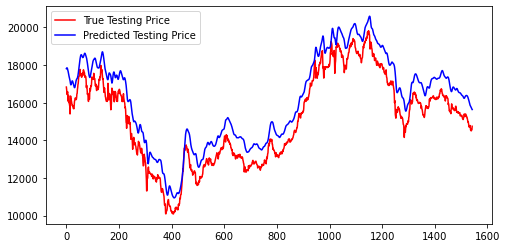

In [17]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()


In [18]:
x = x_test[-1]
num_timesteps = 100
preds = []
for i in range(num_timesteps):
    data = np.expand_dims(x, axis=0)
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    preds.append(prediction[0][0])
    x = np.delete(x, 0, axis=0) # delete first row
    x = np.vstack([x, prediction]) # add prediction

print(preds)

[15639.015, 26999.46, 36778.633, 41162.83, 43121.223, 44022.562, 44459.492, 44681.434, 44799.777, 44865.863, 44904.434, 44927.844, 44942.496, 44951.848, 44957.863, 44961.69, 44963.996, 44965.21, 44965.62, 44965.41, 44964.7, 44963.566, 44962.125, 44960.41, 44958.46, 44956.367, 44954.133, 44951.824, 44949.457, 44947.08, 44944.703, 44942.383, 44940.125, 44937.98, 44935.98, 44934.156, 44932.574, 44931.184, 44930.055, 44929.137, 44928.375, 44927.617, 44926.645, 44925.082, 44922.51, 44918.43, 44912.184, 44903.316, 44891.418, 44876.293, 44858.246, 44858.242, 44858.246, 44858.25, 44858.254, 44858.26, 44858.27, 44858.277, 44858.277, 44858.27, 44858.277, 44858.27, 44858.277, 44858.277, 44858.28, 44858.28, 44858.285, 44858.28, 44858.28, 44858.28, 44858.28, 44858.28, 44858.28, 44858.285, 44858.28, 44858.28, 44858.28, 44858.28, 44858.285, 44858.285, 44858.28, 44858.28, 44858.28, 44858.28, 44858.28, 44858.28, 44858.28, 44858.28, 44858.285, 44858.28, 44858.28, 44858.28, 44858.28, 44858.28, 44858.28, 

In [20]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [21]:
nse = mean_absolute_error(y_test, predictions)

In [22]:
print(nse)

16158.419429052223


In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
MAPE = mean_absolute_percentage_error(y_test, prediction)

In [25]:
print(MAPE)

5470498.751356524


In [26]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, predictions))
rmse

16328.374992712668